In [1]:
import jax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 2

In [3]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)

    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)

    lbound = mean_sim - 1 * std_sim
    ubound = mean_sim + 1 * std_sim

    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

In [4]:
methods_eval = ["lrvga", "sgd-rb", "lofi"]

In [5]:
url_df_all = "https://github.com/probml/probml-data/raw/main/data/rebayes23/uci-models-results.pkl"
df_all = pd.read_pickle(url_df_all)

In [6]:
summary = df_all.groupby(["model", "memory"]).median(numeric_only=True)

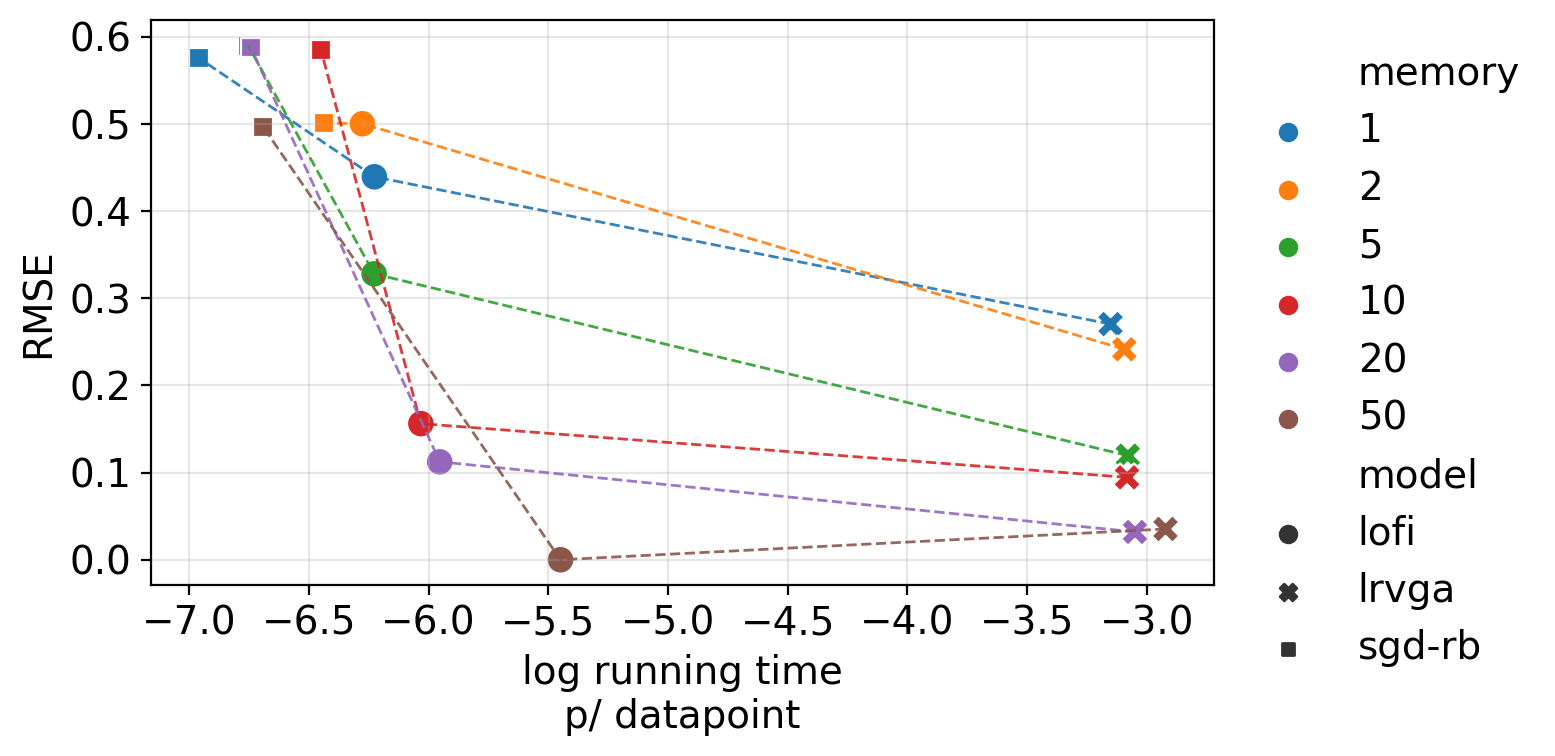

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(
    x="log_running_time_dp",
    y="std_test",
    style="model",
    hue="memory",
    data=summary,
    ax=ax,
    s=100,
    palette="tab10"
)

colors = jnp.arange(0, 10)
colors = plt.cm.tab10(colors)

sizes_mem =[1, 2, 5, 10, 20, 50]
for k, c in zip(sizes_mem, colors):
    x0, y0 = summary.loc[("lrvga", k), ("std_test", "log_running_time_dp")]
    x1, y1 = summary.loc[("lofi", k), ("std_test", "log_running_time_dp")]
    x2, y2 = summary.loc[("sgd-rb", k), ("std_test", "log_running_time_dp")]

    ax.plot([y0, y1, y2], [x0, x1, x2], c=c, linestyle="--", linewidth=1, alpha=0.9)
plt.xlabel("log running time\np/ datapoint")
plt.ylabel("RMSE")
ax.legend(bbox_to_anchor=(1.0, 1.0), frameon=False)
ax.grid(alpha=0.3)

plt.tight_layout()
# plt.savefig("../figures/metric-vs-running-time-median-transpose.pdf")

In [10]:
mapping_name = {
    "lofi": "LOFI",
    "lrvga": "LRVGA",
    "sgd-rb": "RSGD",
}


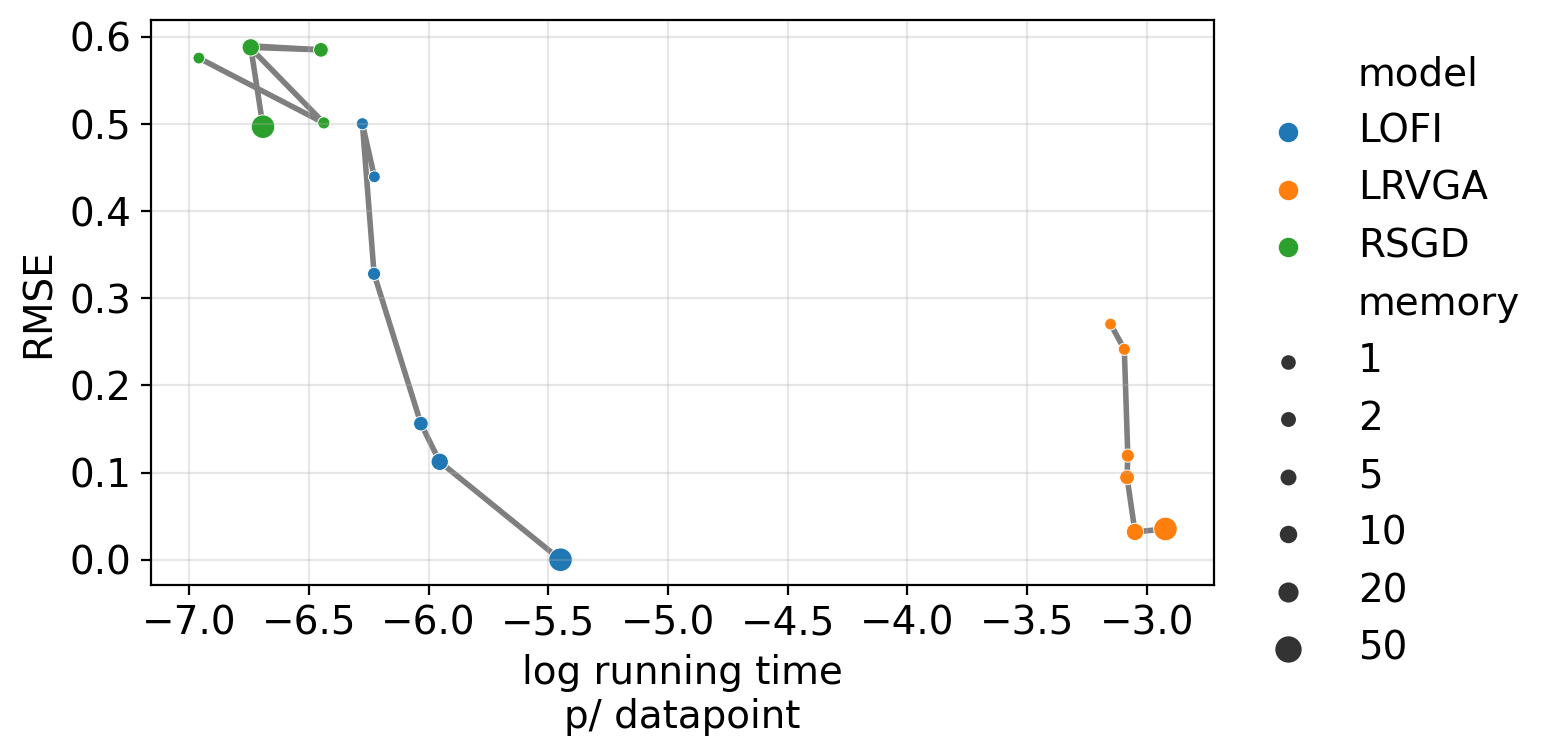

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(
    x="log_running_time_dp",
    y="std_test",
    hue="model",
    size="memory",
    data=summary.rename(mapping_name),
    ax=ax,
    s=100,
    palette="tab10"
)

colors = jnp.arange(3)
colors = {
    "lofi": "tab:blue",
    "lrvga": "tab:orange",
    "sgd-rb": "tab:green"
}

sizes_mem =[1, 2, 5, 10, 20, 50]
for i_init, i_end in zip(sizes_mem[:-1], sizes_mem[1:]):
    for method in methods_eval:
        x0, y0 = summary.loc[(method, i_init), ("std_test", "log_running_time_dp")]
        x1, y1 = summary.loc[(method, i_end), ("std_test", "log_running_time_dp")]
        plt.plot([y0, y1], [x0, x1], zorder=0, c="tab:gray")



plt.xlabel("log running time\np/ datapoint")
plt.ylabel("RMSE")
ax.legend(bbox_to_anchor=(1.0, 1.0), frameon=False)
ax.grid(alpha=0.3)

plt.tight_layout()
# plt.savefig("../figures/metric-vs-running-time-median-by-model.pdf")

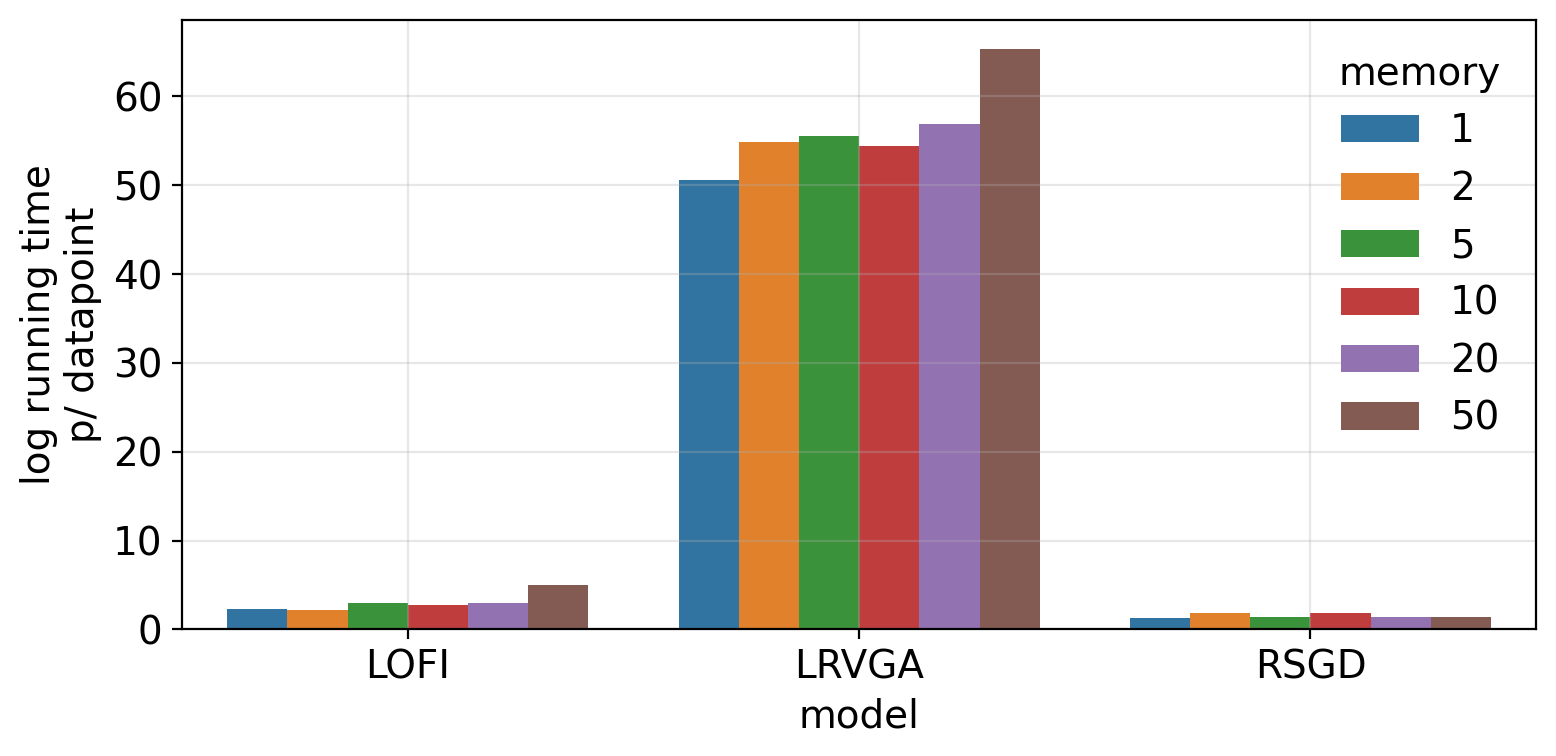

In [42]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    x="model",
    y="running_time",
    hue="memory",
    data=summary.rename(mapping_name).assign().reset_index(),
    ax=ax,
    palette="tab10"
)
ax.legend(bbox_to_anchor=(1.0, 1.0), frameon=False, title="memory")
plt.ylabel("log running time\np/ datapoint")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("running-time-by-model-and-memory.pdf")

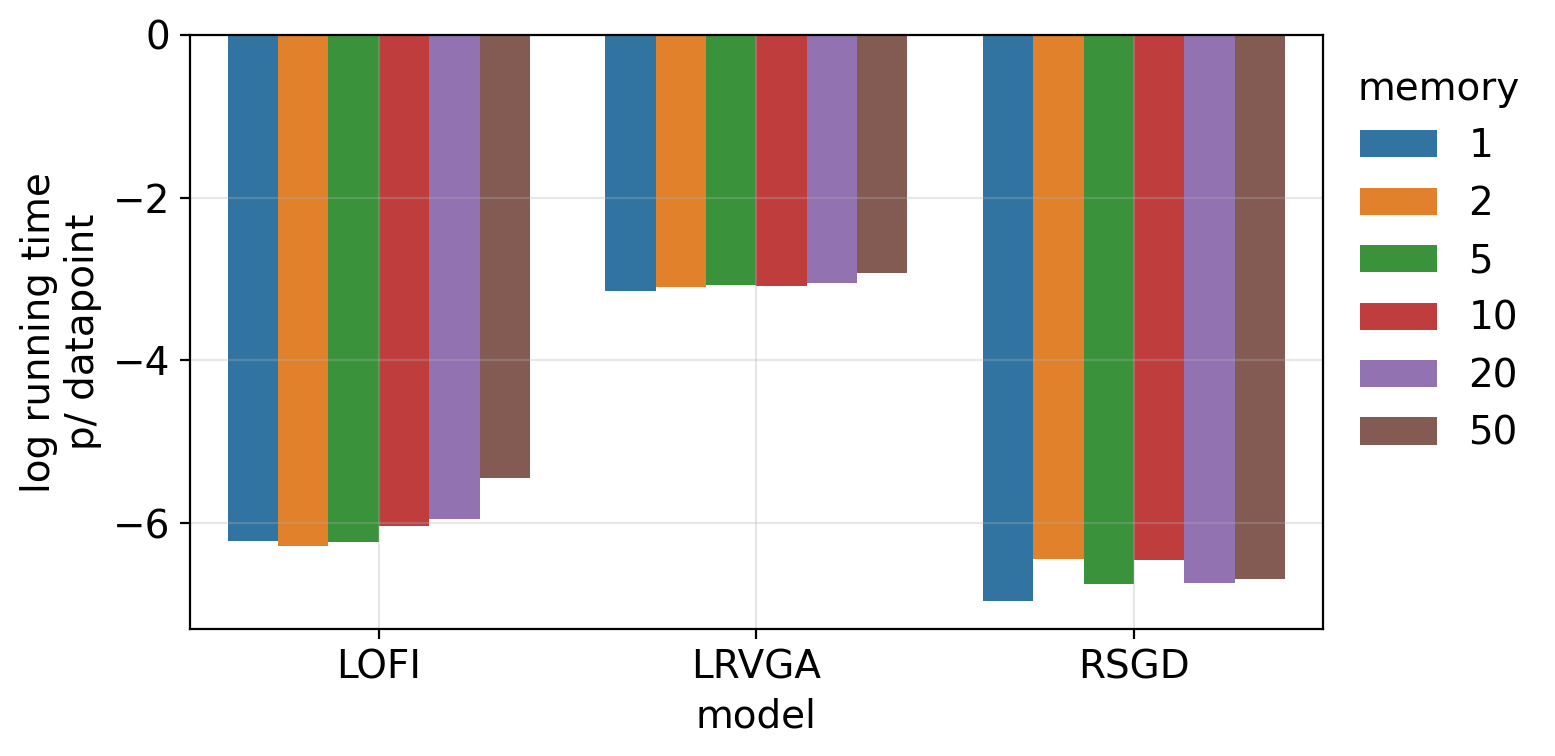

In [43]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    x="model",
    y="log_running_time_dp",
    hue="memory",
    data=summary.rename(mapping_name).assign().reset_index(),
    ax=ax,
    palette="tab10"
)
ax.legend(bbox_to_anchor=(1.0, 1.0), frameon=False, title="memory")
plt.ylabel("log running time\np/ datapoint")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("log-running-time-by-model-and-memory.pdf")

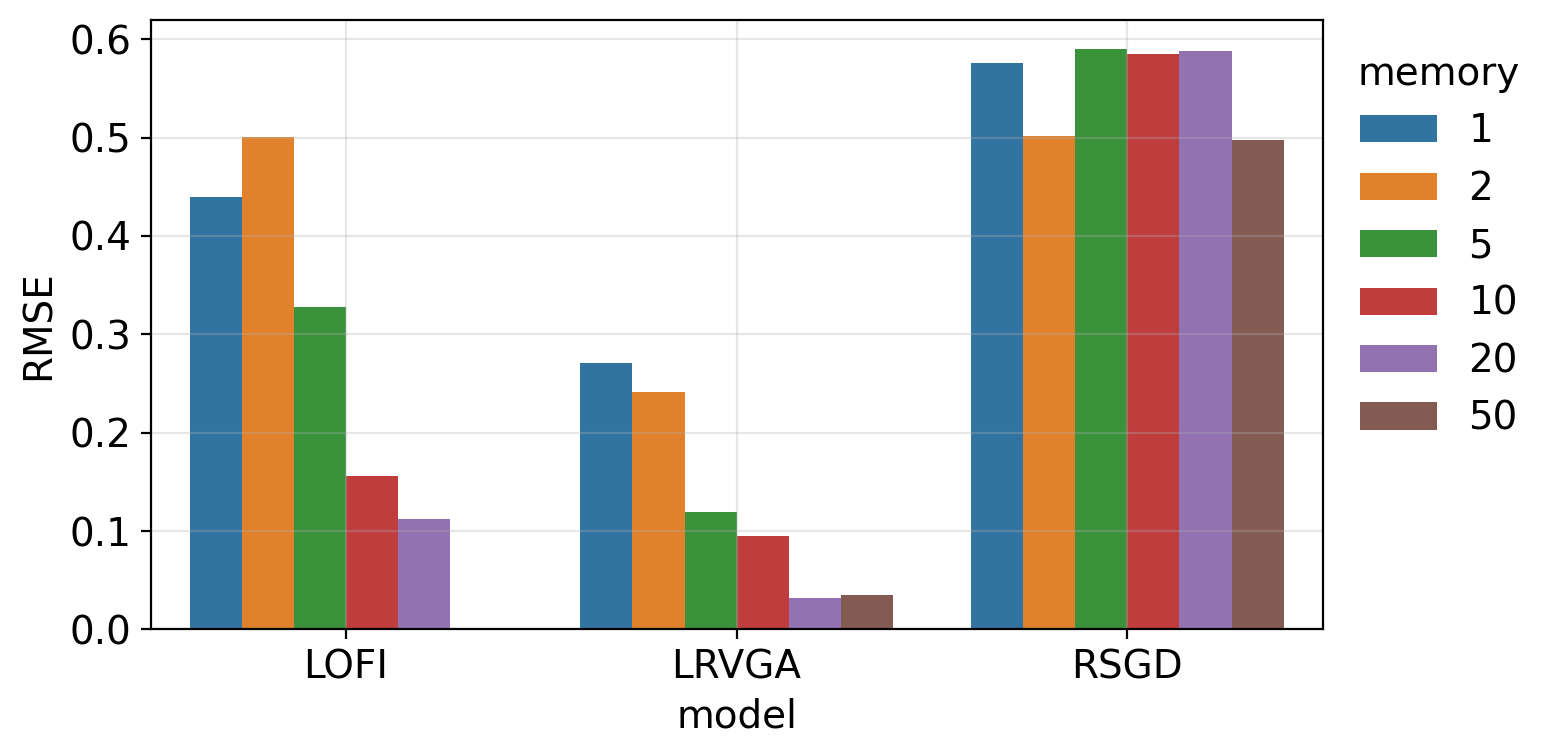

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    x="model",
    y="std_test",
    hue="memory",
    data=summary.rename(mapping_name).reset_index(),
    ax=ax,
    palette="tab10"
)
ax.legend(bbox_to_anchor=(1.0, 1.0), frameon=False, title="memory")
plt.ylabel("RMSE")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("metric-by-model-and-memory.pdf")

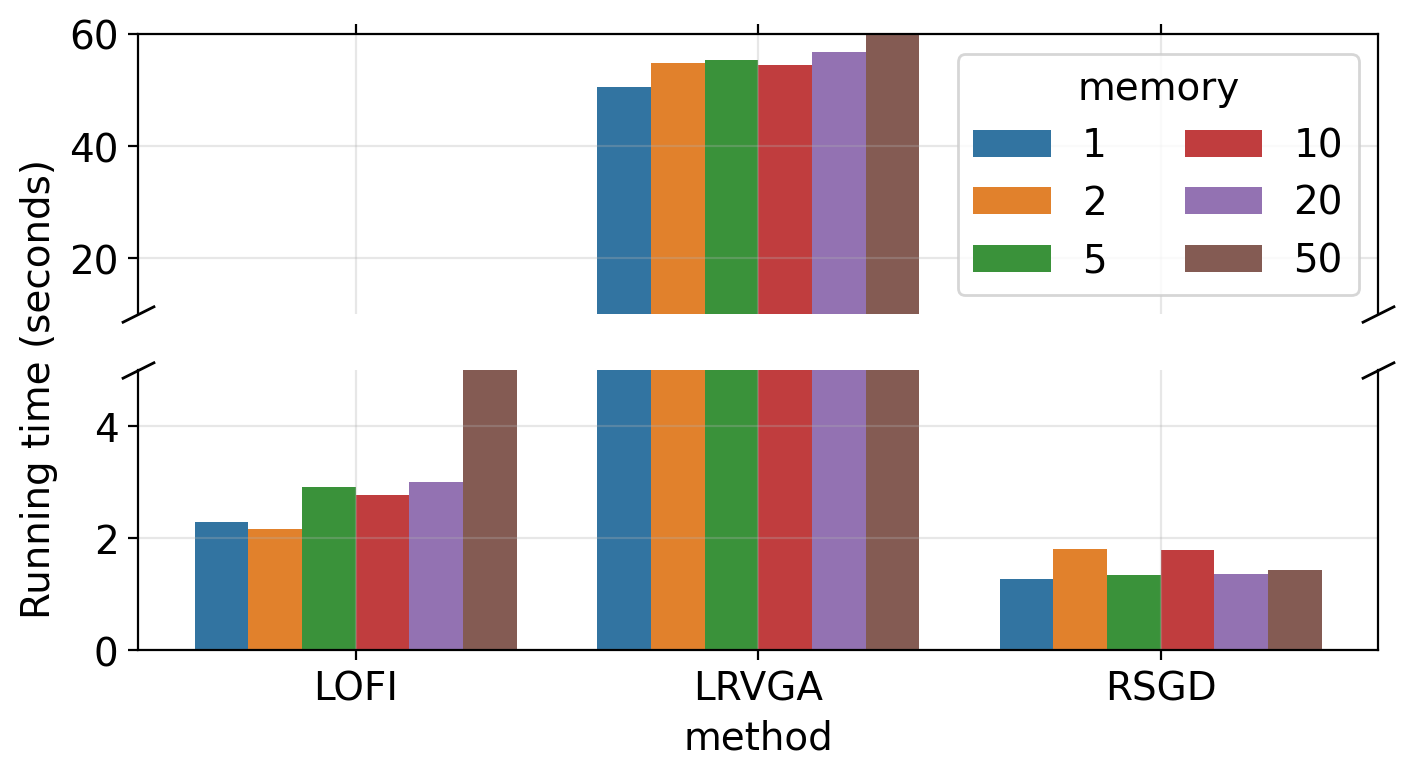

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 4))


sns.barplot(
    x="model",
    y="running_time",
    hue="memory",
    data=summary.rename(mapping_name).assign().reset_index(),
    palette="tab10",
    ax=ax1
)


sns.barplot(
    x="model",
    y="running_time",
    hue="memory",
    data=summary.rename(mapping_name).assign().reset_index(),
    palette="tab10",
    ax=ax2
)

ax1.set_ylim(10, 60)  # outliers only
ax2.set_ylim(0, 5)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax1.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xlabel("method")
ax1.set_ylabel("Running time (seconds)          ", loc="top")
ax2.legend([], frameon=False)
ax1.legend(loc="upper right", title="memory", ncols=2)
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.grid(alpha=0.3)
ax2.grid(alpha=0.3)

# plt.grid(alpha=0.3)

# plt.ylabel("Running time (seconds)")

# plt.tight_layout()
plt.savefig("running-time-by-model-and-memory-clipped.pdf")